# Pre-Modeling: Clean and EDA

Cleaning and EDA for ALRI data to prepare and examine for modeling.

In [22]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt

In [23]:
df = pd.read_excel("data/UCS-satellite.xlsx")

## Cleaning
### Examine Dimention

In [24]:
# Preview and check dataset dimensions
print("=== First 5 Rows ===")
print(df.head(), "\n")

print("=== Last 5 Rows ===")
print(df.tail(), "\n")

rows, cols = df.shape
print(f"=== Dataset Shape ===\nRows: {rows}\nColumns: {cols}")

=== First 5 Rows ===
                  Name of Satellite, Alternate Names  \
0  1HOPSAT-TD (1st-generation High Optical Perfor...   
1                            AAC AIS-Sat1 (Kelpie 1)   
2                                           Aalto-1    
3                                              AAt-4   
4                           ABS-2 (Koreasat-8, ST-3)   

  Current Official Name of Satellite Country/Org of UN Registry  \
0                         1HOPSAT-TD                         NR   
1            AAC AIS-Sat1 (Kelpie 1)             United Kingdom   
2                            Aalto-1                    Finland   
3                              AAt-4                    Denmark   
4                              ABS-2                         NR   

  Country of Operator/Owner                 Operator/Owner       Users  \
0                       USA                   Hera Systems  Commercial   
1            United Kingdom                AAC Clyde Space  Commercial   
2                

In [25]:
# Examine columns and variable
print("=== Column Names ===")
print(df.columns.tolist(), "\n")

print("=== Data Types & Non-Null Counts ===")
print(df.info(), "\n")

print("=== Missing Values ===")
print(df.isnull().sum().sort_values(ascending=False), "\n")

=== Column Names ===
['Name of Satellite, Alternate Names', 'Current Official Name of Satellite', 'Country/Org of UN Registry', 'Country of Operator/Owner', 'Operator/Owner', 'Users', 'Purpose', 'Detailed Purpose', 'Class of Orbit', 'Type of Orbit', 'Longitude of GEO (degrees)', 'Perigee (km)', 'Apogee (km)', 'Eccentricity', 'Inclination (degrees)', 'Period (minutes)', 'Launch Mass (kg.)', 'Dry Mass (kg.)', 'Power (watts)', 'Date of Launch', 'Expected Lifetime (yrs.)', 'Contractor', 'Country of Contractor', 'Launch Site', 'Launch Vehicle', 'COSPAR Number', 'NORAD Number', 'Comments', 'Unnamed: 28', 'Source Used for Orbital Data', 'Source', 'Source.1', 'Source.2', 'Source.3', 'Source.4', 'Source.5', 'Source.6', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 

Let's remove rows and columns that are completely null

In [26]:
# Drop columns where *all* values are NaN
df = df.dropna(axis=1, how='all')

# Drop rows where *all* values are NaN
df = df.dropna(axis=0, how='all')

# Confirm new shape
print(f"After removal → Rows: {df.shape[0]}, Columns: {df.shape[1]}")

After removal → Rows: 7560, Columns: 68


### Explore Columns
Remove duplicate columns and clean column names.

In [27]:
def clean_column_name(col: str) -> str:
    col = col.lower()
    col = col.replace(" ", "_")
    col = col.replace(".", "_")
    return col

# Apply to all columns
df_cleaned = df.copy()
df_cleaned.columns = [clean_column_name(c) for c in df.columns]
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.str.contains("^unnamed")]
source_cols = ['source', 'source_1', 'source_2', 'source_3', 'source_4', 'source_5', 'source_6']
df_cleaned["source"] = df_cleaned[source_cols].astype(str).agg(" ".join, axis=1).str.replace("nan", "").str.strip()
df_cleaned = df_cleaned.drop(columns=source_cols[1:])

# Check new column names
print(df_cleaned.columns.tolist())

['name_of_satellite,_alternate_names', 'current_official_name_of_satellite', 'country/org_of_un_registry', 'country_of_operator/owner', 'operator/owner', 'users', 'purpose', 'detailed_purpose', 'class_of_orbit', 'type_of_orbit', 'longitude_of_geo_(degrees)', 'perigee_(km)', 'apogee_(km)', 'eccentricity', 'inclination_(degrees)', 'period_(minutes)', 'launch_mass_(kg_)', 'dry_mass_(kg_)', 'power_(watts)', 'date_of_launch', 'expected_lifetime_(yrs_)', 'contractor', 'country_of_contractor', 'launch_site', 'launch_vehicle', 'cospar_number', 'norad_number', 'comments', 'source_used_for_orbital_data', 'source']


In [28]:
def drop_long_duplicate_prefix_columns(df, inplace=True, verbose=True):
    """
    For columns where one column name is a strict prefix of another (case-insensitive),
    check if the shorter and the longer column are identical (NaNs in same positions count as equal).
    If identical, drop the longer column.
    
    Returns a list of dropped columns and the matching pairs checked.
    """
    if not inplace:
        df = df.copy()
    cols = list(df.columns)
    # use lowercase keys for matching but keep original names for reporting/drop
    lowered = {c: c.lower().strip() for c in cols}
    # Build candidate pairs: (short, long) where lowered[long].startswith(lowered[short]) and len(long)>len(short)
    candidates = []
    for short in cols:
        for long in cols:
            if short == long:
                continue
            s = lowered[short]
            l = lowered[long]
            # strict prefix (so 'mdays' and 'mdays' won't be considered) and avoid matching when names identical after lower()
            if l.startswith(s) and len(l) > len(s):
                candidates.append((short, long))
    # remove duplicate/redundant candidates by sorting so we prefer the shortest "short" first
    candidates = sorted(candidates, key=lambda x: (x[0].lower(), len(x[1])))
    
    dropped = []
    checked = []
    for short, long in candidates:
        # if long already dropped skip
        if long not in df.columns or short not in df.columns:
            continue
        sser = df[short]
        lser = df[long]
        # Use pandas.Series.equals: it returns True if values are equal and NaNs are in same places
        equal = sser.equals(lser)
        checked.append((short, long, equal))
        if equal:
            df.drop(columns=[long], inplace=True)
            dropped.append((short, long))
            if verbose:
                print(f"Dropped column '{long}' because it is identical to '{short}'.")
    if verbose:
        if not dropped:
            print("No identical prefix-based longer columns found to drop.")
        else:
            print(f"\nDropped {len(dropped)} columns: {dropped}")
    return {"dropped": dropped, "checked_pairs": checked, "df": df if not inplace else None}

# usage (operates in-place by default)
result = drop_long_duplicate_prefix_columns(df_cleaned, inplace=True, verbose=True)

# If you want the result summary:
result['dropped'], len(result['checked_pairs'])

No identical prefix-based longer columns found to drop.


([], 1)

In [29]:
import pandas as pd

def find_duplicate_columns(df, drop=False, verbose=True):
    """
    Find columns in `df` that are perfect duplicates of one another
    (same length, same order, NaNs in the same places).
    
    Parameters
    ----------
    df : pd.DataFrame
    drop : bool, default False
        If True, drop all but the first occurrence of each duplicate group.
    verbose : bool, default True
        If True, print a summary.
    
    Returns
    -------
    dict with:
        - duplicates : list of lists, each inner list is a group of duplicate column names
        - dropped : list of dropped column names (if drop=True)
        - df : new DataFrame if drop=True and inplace=False
    """
    # `df.T.duplicated()` checks duplicate rows after transpose -> duplicate columns
    dup_mask = df.T.duplicated(keep='first')
    duplicate_cols = list(df.columns[dup_mask])

    # Build groups of duplicates for easier inspection
    groups = []
    if duplicate_cols:
        # pair each duplicate with its original "keeper"
        seen = set()
        for col in duplicate_cols:
            if col in seen:
                continue
            # find all cols identical to this col (including itself)
            group = [c for c in df.columns if df[c].equals(df[col])]
            # keep order stable and skip if only itself
            if len(group) > 1:
                groups.append(group)
                seen.update(group)

    if verbose:
        if groups:
            print("Duplicate column groups found:")
            for g in groups:
                print("   ", g)
        else:
            print("No duplicate columns found.")

    dropped = []
    if drop and groups:
        # drop all but first in each group
        to_drop = [c for g in groups for c in g[1:]]
        df.drop(columns=to_drop, inplace=True)
        dropped = to_drop
        if verbose and dropped:
            print(f"\nDropped columns: {dropped}")

    return {"duplicates": groups, "dropped": dropped}

# Example usage:
summary = find_duplicate_columns(df_cleaned, drop=True)
print(summary["duplicates"])   # groups of duplicates
print(summary["dropped"])      # columns removed if drop=True

No duplicate columns found.
[]
[]


In [30]:
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.duplicated()]

Fix purpose variable

In [31]:
def normalize_and_split_column(series):
    """
    Splits cell values by '/', strips whitespace, sorts the resulting list,
    and returns a Series of these normalized lists.
    """
    def process_cell(value):
        s_value = str(value)
        if s_value.lower() in ('nan', 'none', ''):
            return []
        
        if '/' in s_value:
            parts = s_value.split('/')
            parts = [p.strip() for p in parts]
            parts.sort()
            return parts
        else:
            return s_value

        return parts

    return series.apply(process_cell)

columns_to_normalize = [
    col for col in df_cleaned.columns
    if df_cleaned[col].astype(str).str.contains('/', na=False).any() and col != 'source'
]

for col in columns_to_normalize:
    df_cleaned[col] = normalize_and_split_column(df_cleaned[col])

In [32]:
NUMERIC_COLS_TO_CLEAN = [
    'longitude_of_geo_(degrees)', 'perigee_(km)', 'apogee_(km)', 
    'eccentricity', 'inclination_(degrees)', 'period_(minutes)',
    'launch_mass_(kg_)', 'dry_mass_(kg_)', 'power_(watts)',
    'expected_lifetime_(yrs_)',
    'norad_number' # Added norad_number for cleaning
]

def extract_numeric(series):
    """
    Cleans a series to extract the first continuous block of digits (and optional decimal)
    and converts it to a float. Non-numeric or missing values become NaN.
    """
    cleaned_series = series.astype(str).str.replace(',', '', regex=False)
    # Regex to find the first floating point or integer number
    numeric_values = cleaned_series.str.extract(r'(\d+\.?\d*)', expand=False)
    return pd.to_numeric(numeric_values, errors='coerce')

# Apply the cleaning function to all defined numeric columns
print("\n--- Starting Universal Cleaning ---")
for col in NUMERIC_COLS_TO_CLEAN:
    # We use a try/except block just in case a column was renamed or dropped 
    # outside of this script's scope, ensuring the code is robust.
    try:
        df_cleaned[col] = extract_numeric(df_cleaned[col])
        print(f"Cleaned column: {col}")
    except KeyError:
        print(f"Warning: Column '{col}' not found in DataFrame. Skipping.")

# Drop any rows where the key plotting values couldn't be extracted
df_cleaned.dropna(subset=['launch_mass_(kg_)', 'power_(watts)'], inplace=True)

print("\n--- Cleaning Complete ---")
print(f"Data cleaned. {len(df_cleaned)} rows remaining for plotting.")
print("\nExample of cleaned data in 'norad_number':")
print(df_cleaned['norad_number'].head(10))


--- Starting Universal Cleaning ---
Cleaned column: longitude_of_geo_(degrees)
Cleaned column: perigee_(km)
Cleaned column: apogee_(km)
Cleaned column: eccentricity
Cleaned column: inclination_(degrees)
Cleaned column: period_(minutes)
Cleaned column: launch_mass_(kg_)
Cleaned column: dry_mass_(kg_)
Cleaned column: power_(watts)
Cleaned column: expected_lifetime_(yrs_)
Cleaned column: norad_number

--- Cleaning Complete ---
Data cleaned. 576 rows remaining for plotting.

Example of cleaned data in 'norad_number':
2     42775
4     39508
7     28184
8     25924
40    33460
43    31304
58    35942
59    39078
64    28252
67    33275
Name: norad_number, dtype: int64


### Outlier Detection
Detect outliers with IQR, Isolation Forest, Local Outlier Factor, SVM, and Elliptic Envelope.

In [33]:
numeric_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns

In [34]:
outlier_summary = pd.DataFrame(columns=['variable', 'n_outliers', 'percent_outliers'])

for col in numeric_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    n_out = outliers.shape[0]
    pct_out = n_out / df_cleaned.shape[0] * 100
    
    outlier_summary = pd.concat([outlier_summary, pd.DataFrame({
        'variable': [col],
        'n_outliers': [n_out],
        'percent_outliers': [pct_out]
    })])

# Sort by % of outliers descending
outlier_summary = outlier_summary.sort_values(by='percent_outliers', ascending=False).reset_index(drop=True)

# Display summary
print(outlier_summary)

                      variable n_outliers  percent_outliers
0                 eccentricity        107         18.576389
1                power_(watts)         73         12.673611
2   longitude_of_geo_(degrees)         40          6.944444
3               dry_mass_(kg_)         23          3.993056
4                  apogee_(km)          7          1.215278
5             period_(minutes)          2          0.347222
6            launch_mass_(kg_)          1          0.173611
7                 perigee_(km)          0          0.000000
8        inclination_(degrees)          0          0.000000
9     expected_lifetime_(yrs_)          0          0.000000
10                norad_number          0          0.000000


C:\Users\afraa\AppData\Local\Temp\ipykernel_20416\3417793413.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outlier_summary = pd.concat([outlier_summary, pd.DataFrame({


   Isolation Forest  Local Outlier Factor  One-Class SVM  Elliptic Envelope
0             False                     1           True              False
1             False                     1          False              False
2             False                     1          False              False
3             False                     1          False              False
4             False                     1          False              False


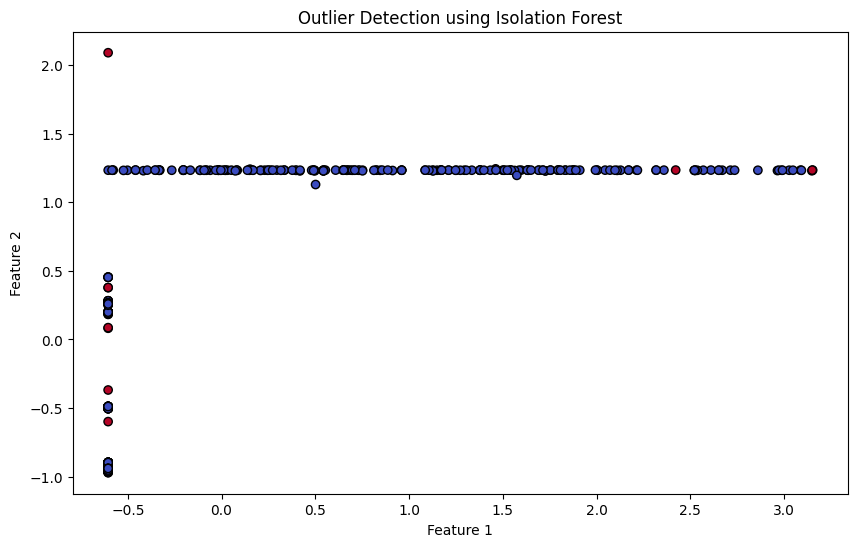

In [35]:
# Standardize the data
scaler = StandardScaler()
X = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].median())
X_scaled = scaler.fit_transform(X)

# Initialize the outlier detection models
models = {
    "Isolation Forest": IsolationForest(contamination=0.05, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.05),
    "One-Class SVM": OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.05)
}

# Fit models and predict outliers
outlier_results = {}
for name, model in models.items():
    if name == "Local Outlier Factor":
        # LOF uses fit_predict which returns -1 for outliers and 1 for inliers
        outlier_results[name] = model.fit_predict(X_scaled)
    else:
        # Other models use fit_predict and return 1 for inliers and -1 for outliers
        outlier_results[name] = model.fit_predict(X_scaled) == -1

# Convert results to DataFrame
outlier_df = pd.DataFrame(outlier_results)

# Display the first few rows of the outlier detection results
print(outlier_df.head())

plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=outlier_df['Isolation Forest'], cmap='coolwarm', edgecolors='k')
plt.title("Outlier Detection using Isolation Forest")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Mulit-Colinearity
Detect dependencies amongst variables with PCA.

In [36]:
X = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].mean())
X_scaled = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X_scaled)

# Variance explained
explained_var = pca.explained_variance_ratio_
print("Explained variance per component:", explained_var)

# PCA loadings
loadings = pd.DataFrame(pca.components_.T, index=numeric_cols)
print(loadings)

Explained variance per component: [0.53546539 0.12871929 0.09079745 0.06626478 0.05561111 0.04134365
 0.03432236 0.02644838 0.01113571 0.00777332 0.00211856]
                                  0         1         2         3         4   \
longitude_of_geo_(degrees)  0.325150  0.013835 -0.019144 -0.051082 -0.302772   
perigee_(km)                0.386539 -0.077861 -0.104931 -0.096254 -0.032510   
apogee_(km)                 0.319734 -0.312767 -0.093919 -0.296430  0.495600   
eccentricity                0.074582  0.214654  0.890736 -0.379421  0.077281   
inclination_(degrees)      -0.352093  0.048274  0.048365  0.124951  0.244519   
period_(minutes)            0.366775 -0.237023 -0.095093 -0.225897  0.316203   
launch_mass_(kg_)           0.365792  0.148603  0.021684  0.253501 -0.046129   
dry_mass_(kg_)              0.263123  0.199883  0.189813  0.641734  0.387042   
power_(watts)               0.343413  0.218031  0.046838  0.254607 -0.144129   
expected_lifetime_(yrs_)    0.205518  0.53

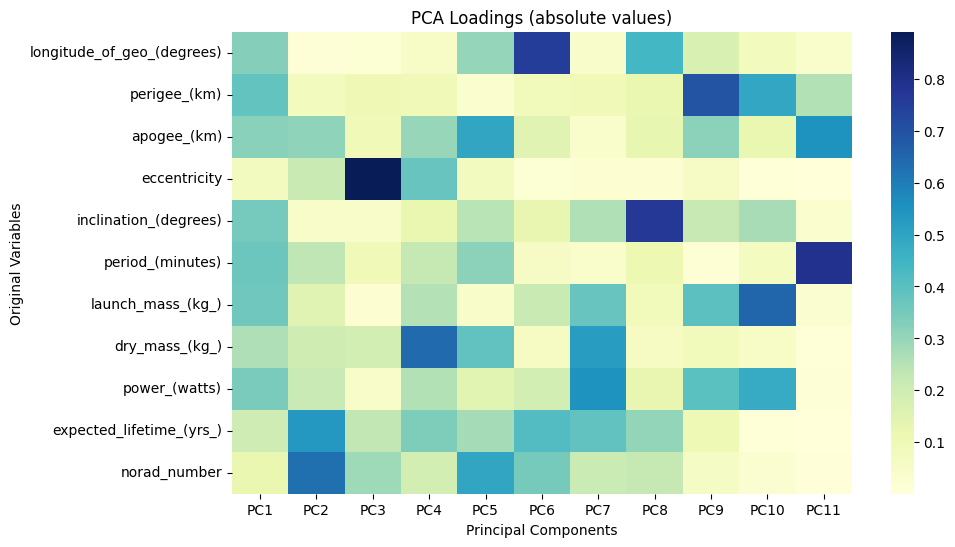

In [37]:
plt.figure(figsize=(10,6))
sns.heatmap(abs(loadings),
            cmap="YlGnBu",
            yticklabels=numeric_cols,
            xticklabels=[f"PC{i+1}" for i in range(loadings.shape[1])])
plt.title("PCA Loadings (absolute values)")
plt.xlabel("Principal Components")
plt.ylabel("Original Variables")
plt.show()

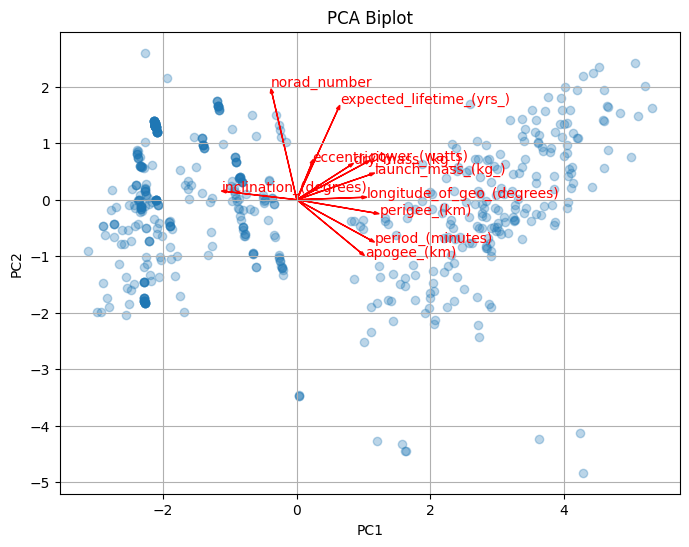

In [38]:
pca2 = PCA(n_components=2).fit(X_scaled)
scores = pca2.transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(scores[:,0], scores[:,1], alpha=0.3)

for i, var in enumerate(numeric_cols):
    plt.arrow(0, 0, pca2.components_[0,i]*3, pca2.components_[1,i]*3,
              color='r', head_width=0.05)
    plt.text(pca2.components_[0,i]*3.2, pca2.components_[1,i]*3.2, var, color='r')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot")
plt.grid()
plt.show()

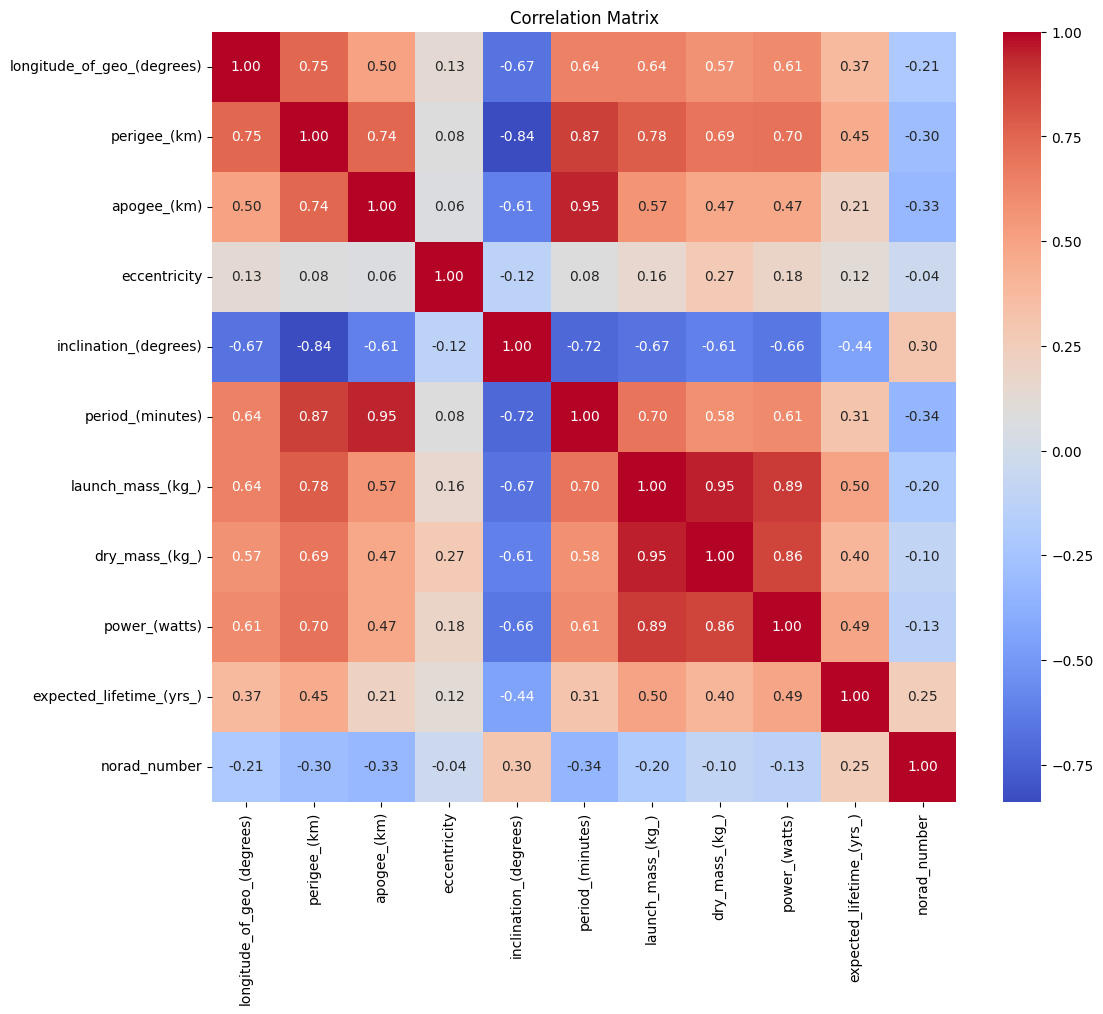

Highly correlated pairs (|r| >= 0.7):
longitude_of_geo_(degrees) ↔ perigee_(km): r = 0.75
perigee_(km) ↔ apogee_(km): r = 0.74
perigee_(km) ↔ inclination_(degrees): r = -0.84
perigee_(km) ↔ period_(minutes): r = 0.87
perigee_(km) ↔ launch_mass_(kg_): r = 0.78
perigee_(km) ↔ power_(watts): r = 0.70
apogee_(km) ↔ period_(minutes): r = 0.95
inclination_(degrees) ↔ period_(minutes): r = -0.72
launch_mass_(kg_) ↔ dry_mass_(kg_): r = 0.95
launch_mass_(kg_) ↔ power_(watts): r = 0.89
dry_mass_(kg_) ↔ power_(watts): r = 0.86


In [39]:
# Group plots and summary tables

corr_matrix = df_cleaned[numeric_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# --- 3️⃣ Identify highly correlated pairs ---
threshold = 0.7
high_corr_pairs = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        r = corr_matrix.iloc[i, j]
        if abs(r) >= threshold:
            high_corr_pairs.append((numeric_cols[i], numeric_cols[j], r))

print("Highly correlated pairs (|r| >= 0.7):")
for c1, c2, r in high_corr_pairs:
    print(f"{c1} ↔ {c2}: r = {r:.2f}")

# EDA
Examine variable distributions

In [40]:
# # Examine variable distributions

# # --- 1️⃣ Numeric variables ---
# for col in numeric_cols:
#     plt.figure(figsize=(12,4))
    
#     # Histogram + KDE
#     plt.subplot(1,2,1)
#     sns.histplot(df_cleaned[col], kde=True, bins=30)
#     plt.title(f"Distribution of {col}")
    
#     # Boxplot (for outliers)
#     plt.subplot(1,2,2)
#     sns.boxplot(x=df_cleaned[col])
#     plt.title(f"Boxplot of {col}")
    
#     plt.show()

# # --- 2️⃣ Categorical variables ---
# for col in cat_cols:
#     plt.figure(figsize=(10,4))
#     sns.countplot(y=df_cleaned[col], order=df_cleaned[col].value_counts().index)
#     plt.title(f"Category Counts of {col}")
#     plt.show()

In [41]:
# for col in numeric_cols:
#     data = df_cleaned[col].dropna()

#     print(f"\n=== {col} ===")
#     # Shapiro–Wilk test
#     stat, p = stats.shapiro(data)
#     print(f"Shapiro-Wilk: stat={stat:.3f}, p={p:.3f}")

#     # Anderson–Darling test (for normality)
#     anderson_result = stats.anderson(data, dist='norm')
#     print(f"Anderson-Darling: stat={anderson_result.statistic:.3f}, "
#           f"critical_values={anderson_result.critical_values}, sig={anderson_result.significance_level}")

#     # D’Agostino and Pearson omnibus test
#     stat, p = stats.normaltest(data)
#     print(f"D’Agostino/Pearson: stat={stat:.3f}, p={p:.3f}")


In [42]:
df_cleaned.to_csv("data/statellites_clean.csv")